In [1]:
import pandas as pd

### Data Preparation and Exploration

In [2]:
df=pd.read_csv('C:/Users/RUTU/Desktop/Data Science/DS_New Assi/Timeseries/Timeseries/exchange_rate.csv')
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


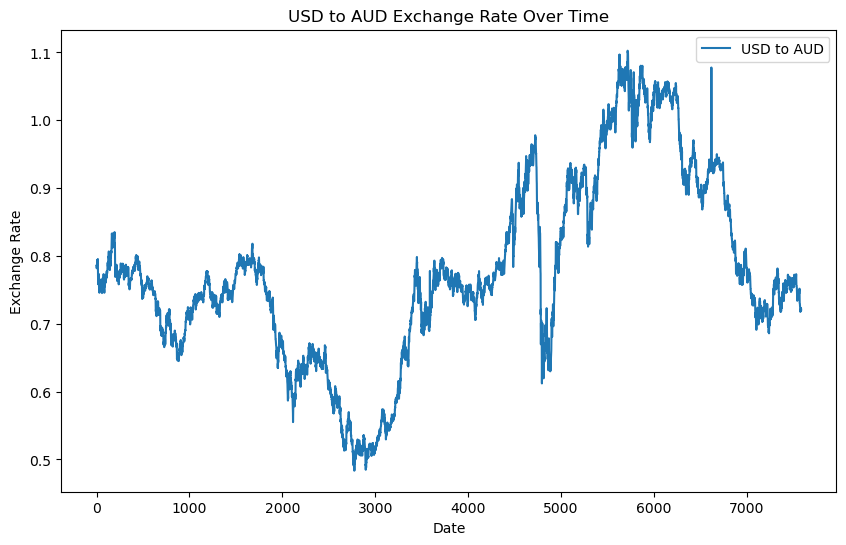

In [15]:
#Initial Exploration
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df['Ex_rate'], label='USD to AUD')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


In [7]:
#Data Preprocessing
# Check for missing values
df.isnull().sum()

# Fill missing values (if any)
df.fillna(method='ffill', inplace=True)

# Check for any remaining missing values
df.isnull().sum()


date       0
Ex_rate    0
dtype: int64

### Model Building - Arima

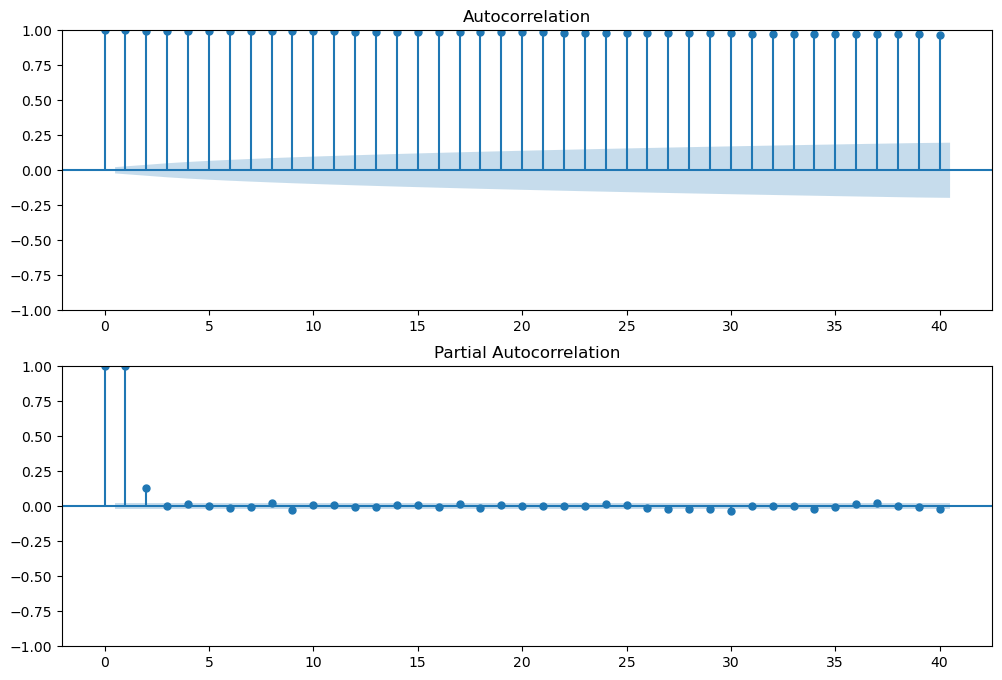

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Ex_rate'], ax=ax[0], lags=40)
plot_pacf(df['Ex_rate'], ax=ax[1], lags=40)
plt.show()


In [19]:
#Model Fitting
# Define the ARIMA model (example parameters)
p, d, q = 1, 1, 1  # Replace with appropriate values based on ACF/PACF analysis
model = ARIMA(df['Ex_rate'], order=(p, d, q))

# Fit the model
arima_result = model.fit()

# Print the summary of the model
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Mon, 22 Jul 2024   AIC                         -56102.322
Time:                        17:01:10   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

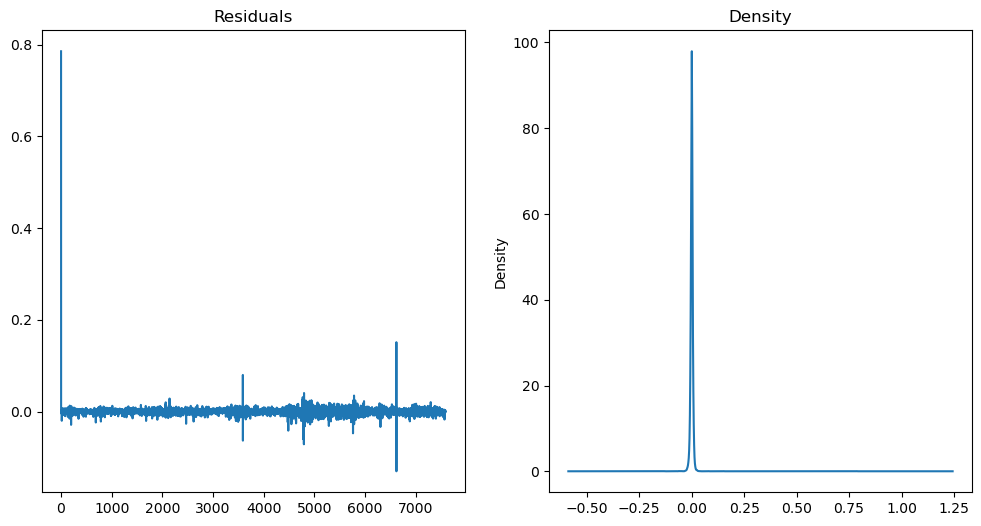

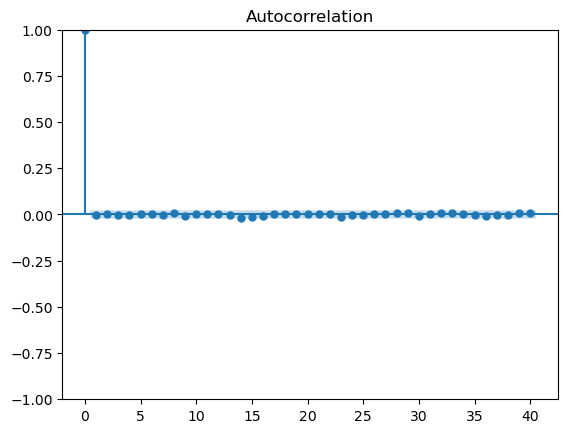

In [20]:
#diagnostics
# Plot residuals
residuals = arima_result.resid
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Perform diagnostic tests
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=40)
plt.show()


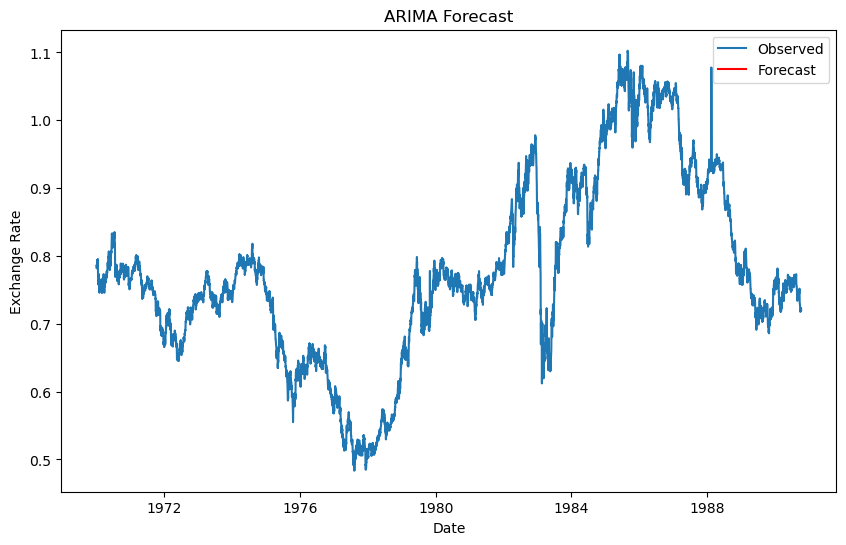

In [21]:
#forecasting
# Forecast
forecast = arima_result.get_forecast(steps=30)
forecast_index = pd.date_range(start=df.index[-1], periods=30, freq='D')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(df['Ex_rate'], label='Observed')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


### Model Building- Exponential Smoothing

In [22]:
#model selection
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Define the Exponential Smoothing model
model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12)


In [23]:
#parameter Optimization-Exponential Smoothing
# Fit the model
hw_result = model.fit()

# Print the summary of the model
print(hw_result.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77624.575
Trend:                         Additive   BIC                         -77513.626
Seasonal:                      Additive   AICC                        -77624.485
Seasonal Periods:                    12   Date:                 Mon, 22 Jul 2024
Box-Cox:                          False   Time:                         17:08:24
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8702083                alpha                 True
smoothing_trend          

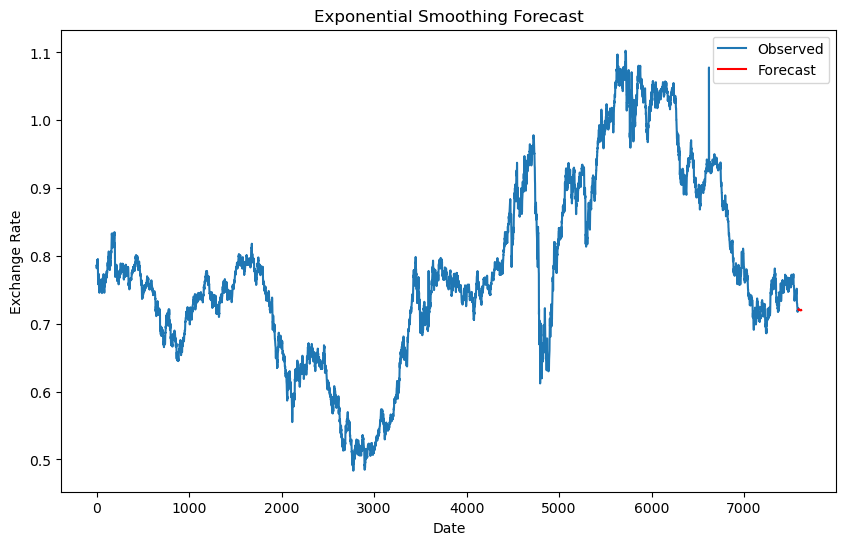

In [24]:
#forecasting - Exponential Smoothing
# Forecast
hw_forecast = hw_result.forecast(steps=30)

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(df['Ex_rate'], label='Observed')
plt.plot(hw_forecast, label='Forecast', color='red')
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


### Evaluation and comparison

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Forecast ARIMA
arima_forecast = arima_result.get_forecast(steps=30).predicted_mean

# Compute error metrics
mae_arima = mean_absolute_error(df['Ex_rate'][-30:], arima_result.forecast(steps=30).predicted_mean)
rmse_arima = mean_squared_error(df['Ex_rate'][-30:], arima_result.forecast(steps=30).predicted_mean, squared=False)
mape_arima = np.mean(np.abs(arima_forecast - df['Ex_rate'][-30:]) / df['Ex_rate'][-30:]) * 100

mae_hw = mean_absolute_error(df['Ex_rate'][-30:], hw_forecast)
rmse_hw = mean_squared_error(df['Ex_rate'][-30:], hw_forecast, squared=False)
mape_hw = np.mean(np.abs(hw_forecast - df['Ex_rate'][-30:]) / df['Ex_rate'][-30:]) * 100

print(f'ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}, MAPE: {mape_arima}')
print(f'Holt-Winters - MAE: {mae_hw}, RMSE: {rmse_hw}, MAPE: {mape_hw}')


AttributeError: 'Series' object has no attribute 'predicted_mean'